# On Random Number Generation

<span style="font-size: 12px; color: #777; float: right;">This cell contains Latex macros.</span>
$$
\newcommand{\ket}[1]{| #1 \rangle}
\newcommand{\bra}[1]{\langle #1 |}
$$

This is `Constantine Quantum Technologies`'s solution to ORCA Computing's challenge `Random number generation using boson sampling`.

### Team

- Abdellah Tounsi
- Amina Sadik
- Mohamed Messaoud Louamri
- Nacer eddine Belaloui
- Wafa Makhlouf
- Zakaria Benhaddouche

### Content:
* [Why do we need RNG?](#Why-do-we-need-RNG?)
    * [Science](#Science)
    * [Security](#Security)
* [The problem at hand](#The-problem-at-hand)
* [Making an RNG device](#Making-an-RNG-device)
    * [The (quantum) entropy source(s)](#The-(quantum)-entropy-source(s))
        * [Quantum RNG: Qubits](#Quantum-RNG:-Qubits)
        * [Quantum RNG: Boson Sampling](#Quantum-RNG:-Boson-Sampling)
    * [The post-processing](#The-post-processing)
        * [The Von Neumann post processing steps](#The-Von-Neumann-post-processing-steps:)
        * [The theory behind the Von Neumann post processing: independent elements](#The-theory-behind-the-Von-Neumann-post-processing:-independent-elements)
        * [the Von Neumann Post processing: dependent elements](#the-Von-Neumann-Post-processing:-dependent-elements)
        * [Post-processing: dependent elements, the unbiased way](#Post-processing:-dependent-elements,-the-unbiased-way)
* [Testing the randomness](#Testing-the-randomness)
* [The CQT RNG package](#The-CQT-RNG-package)
    * [Qubits-based Simulator](#Qubits-based-Simulator)

### Installation

To download, install, and import all the necessary packages and scripts. Uncomment and run the following commands:

In [ ]:
# !pip install cqt_rng

In [1]:
# !git clone https://github.com/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing.git

In [2]:
# !pip install Random-number-generation-using-boson-sampling---ORCA-Computing/

In [3]:
# !wget -P scripts/ https://raw.githubusercontent.com/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing/main/challenge/scripts/study_boson_sampler.py

In [ ]:
# !wget -P scripts/ https://raw.githubusercontent.com/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing/main/challenge/scripts/constants.py

In [14]:
%run scripts/study_boson_sampler.py

In [ ]:
%run scripts/constants.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

In [16]:
from cqt_rng.entropy_sources.simulators.boson_sampler import BosonSampler
from cqt_rng.utils import generate_haar_unitary

## Why do we need RNG?

### Science

When, we think about science we think about it being deterministic and systematic both in the results and the methods. It might look strange that randomness has anything to do with science. Yet, there exist a whole class of [randomized algorithms](https://en.wikipedia.org/wiki/Randomized_algorithm) used in the scientic realm which are based on randomness. The most populars of these algorithms are called the [Monte Carlo algorithms](https://en.wikipedia.org/wiki/Monte_Carlo_algorithm). An example of such an algorithm used to determine the value of π (which is 3.1415..., in case you forgot 😄) us shown below:

The algorithm is as follows:
1. We throw random "darts" on a 1x1 square.
1. We calculate the number of "darts" that hit the interior of a circle whose center is the point (0.5, 0.5) and whose radius is 0.5.
1. The estimated value of π would be 4 * Number of darts inside the circle / Total number of darts thrown.

An animation of the process is given below, in the beginning we will send darts one by one (so that you can visualize the step) and after 50 darts we will send rounds of 1000 darts (so that we can reach a higher number of darts thrown).  

<img src="https://s4.gifyu.com/images/montecarlo_pi_good.gif" style="height: 300px" />

As you can see, we are converging towards the known value of π, how is this possible? Let's try to understand it.

The area of the circle is  $0.5^2 \pi$, and the area of the square is $1$. If we send darts uniformly (which is what we are doing). The probability that a dart ends inside the circle is $P =\text{Area of the circle} / \text{Area of the square} = 0.5^2 \pi/1 = \pi/4$. We can approximate this probability by sending a very large number of darts on the square $P = \text{Number of darts inside the circle}/\text{Total number of darts}$ and then we would find that: 

$$\pi = 4 P = 4  \frac{\text{Number of darts inside the circle}}{\text{Total number of darts}}$$

Let's see what we would get if there was biasness in the darts we threw (ie: the probability that a darts ends in a certain area is higher than the probability that it ends in another (and equal) area):

<img src="https://s4.gifyu.com/images/montecarlo_pi_bad.gif" style="height: 300px"/>

As you can see from this animation, the darts are not uniformly thrown (they are sent closer to the center of the square). The value of π that we get is wrong 3.46 instead of 3.14.

Obviously, this is just a trivial example. Imagine now that we had to use such an randomized algorithm to develop a drug for example. A small bias in the random numbers would lead to wrong results which would lead to dramatic results. This shows how important it is to **unbiased** random numbers.

For a more technical, explanation we will refer to both these papers (among others):
1. [Quality of random number generators significantly affects results of Monte Carlo simulations for organic and biological systems](https://pubmed.ncbi.nlm.nih.gov/20734313/)
1. [Random numbers for simulation](https://dl.acm.org/doi/10.1145/84537.84555)

### Security

Another critical application of random numbers generators are in cryptography. 

So, why are unbiased bitstrings more secure?

Let's assume someone (who we will call Bob) captured an encrypted message that you sent. Bob knows which algorithm that you used to encrypt the message, he also knows the length of the key. Let's also assume that he knows the proportions of 0s and 1s in key but Bob doesn't know the key itself. 

To crack your message, he decided to use a bruteforce method (i.e: test every single possible key which matches the proportions which he is aware of). Finally, let's assume that to bruteforce the message. He uses a computer which can test one key every hour.


#### Example 1:
For the sake of simplicity, let's consider that the key has 4 bits and that its made of 1 0-bits and 3 1-bits.
What are all the possible keys that Bob needs to test to crack the message? How many keys made of 4 bits have 1 zero and 3 ones? Let's count:

```
0111
1011
1101
1110
```

There are four states. The general method to find the number of keys $N$ of length $n$ with $r$ zeros is to use the formula (more detaild can be found in any basic probability course):

$$N = nCr = \frac{n!}{r! (n - r)!}$$ 


So, it would take up to 4 hours for bob to crack your encrypted message.
#### Example 2:
Let's consider that the key has 16 bits. And see what proportion of bits leads to a higher number of keys $N$.

In [5]:
for i in range(0, 17):
    print(f"The number of keys of length {16} with {i}-zeros and {16-i}-ones is: {int(comb(16, i))}")

The number of keys of length 16 with 0-zeros and 16-ones is: 1
The number of keys of length 16 with 1-zeros and 15-ones is: 16
The number of keys of length 16 with 2-zeros and 14-ones is: 120
The number of keys of length 16 with 3-zeros and 13-ones is: 560
The number of keys of length 16 with 4-zeros and 12-ones is: 1820
The number of keys of length 16 with 5-zeros and 11-ones is: 4368
The number of keys of length 16 with 6-zeros and 10-ones is: 8008
The number of keys of length 16 with 7-zeros and 9-ones is: 11440
The number of keys of length 16 with 8-zeros and 8-ones is: 12870
The number of keys of length 16 with 9-zeros and 7-ones is: 11440
The number of keys of length 16 with 10-zeros and 6-ones is: 8008
The number of keys of length 16 with 11-zeros and 5-ones is: 4368
The number of keys of length 16 with 12-zeros and 4-ones is: 1820
The number of keys of length 16 with 13-zeros and 3-ones is: 560
The number of keys of length 16 with 14-zeros and 2-ones is: 120
The number of keys 

As you can see, the number of possible keys is at his highest when the proportion is of 50%. And this is a general result no matter the length of the key $n$, the number of possible keys is at its highest whenever the proportion is of 50%.



#### Example 3:

In [41]:
from scipy.stats import entropy

def calculate_entropy(arr):
    propor = np.unique(arr, return_counts=True)
    return entropy(propor[1] / len(arr), base=len(propor[0]))

In [36]:
arr1 = np.append(np.full(3, 0), np.full(7, 1))

In [42]:
calculate_entropy(arr1)

0.8812908992306927

In [44]:
arr2 = np.append(np.full(5, 0), np.full(5, 1))

In [45]:
calculate_entropy(arr2)

1.0

## The problem at hand

We saw how important it is to generate random numbers. Our task is to find a procedure that generates **uniform, unbiased, unreproducible random numbers with a sufficient rate**.

The problem might look simple. If you used `python`, you probably know that we have whole packages (`random`, `np.random`, ...) to generate random numbers. Let's take a look at `numpy`random number generator:

#### Pseudo-RNG

Let's see how to generate a random bitstring in python.

In [17]:
np.random.randint(0, 2, size = 10)

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

That was easy as "py". But, how random are these numbers? The output above looks pretty random, so did we solve our problem already? Was it so trivial? No, `numpy` (and other prng) generate numbers which are **approximately random** using arithmetical methods. These numbers might be useful in a variety of applications but not in **critical applications** like security and science.

Let's try to understand how `numpy` generate its random numbers. For this, let's pick an [oversimplified algorithm](https://en.wikipedia.org/wiki/Pseudorandom_number_generator#Implementation).

In [18]:
def prng(seed, size):
    bitstring = np.empty(size, dtype=int)
    a, b = 17, 19 # a and b need to be prime numbers
    
    for i in range(size):
        num = seed * a
        bitstring[i] = np.round((num**3 % b) / b)
        seed += 1
        
    return bitstring

And generate a bitstring of length 95:

In [19]:
prng(42, 19 * 5)

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

This looks pretty random doesn't it? However, it is **not**:

1. Everyone who knows your algorithm and knows the initial state (the seed) would be able to **reproduce** your results.

In [20]:
prng(42, 19 * 5) # same output

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

2. If you look closely you will see that their is a pattern that get's repeated:

In [21]:
np.reshape(_, (5, 19))

array([[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]])

You can check that the same happens with numpy, let's pick the seed to be `12` and run `np.random.randint`. On my PC, I get: `array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])`. Try it on your PC, you would get the same results. This means that if their is a breach which would allow someone to know your `seed`. That person can easily reproduce all the random numbers you generate.

In [22]:
np.random.seed(12)
np.random.randint(0, 2, size = 10)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])

Of course, there exists more advanced algorithm's to generate random numbers but generating **truly random** numbers using a classical computer or a classical system is impossible. This means that we need to change paradigm. We should use a **Quantum** computer to solve our problem. 

Indeed, a key property of quantum system is the **randomness of the measurements** as long as the quantum state isn't in an eigenstate of the measured observable. 

> In quantum mechanics, a (quantum) system is said to be in a particular quantum state. For example, an electron can be in a spin up state ⬆️, we would write $\ket{Electron State} = \ket{⬆️}$. If we measure it, we will **with certainty** find its spin to be up. In this case, we say that the electron is in an eigenstate of the observable $S_z$. The electron could also be in a **superposition** of spin up ⬆️ and spin down ⬇️, we would write $\ket{Electron State} = \alpha\ket{⬆️} + \beta\ket{⬇️}$. In this case, the electron is not in an eigestate of the obserbable $S_z$ and a measurement has probability $|\alpha|^2$ to yield spin up ⬆️ and $|\beta|^2$ to yield spin down ⬇️.

So, to make a **truly random and unreproducible** entropy source. We should:
1. Pick a quantum system. 
1. Make sure that the system's state is an superposition.
1. Carry a measurement.
1. And we would obtain **truly random** and **unreproducible** results.

Let's see two examples of quantum systems which can be used:

## Making an RNG device

We can decompose the process of generating random numbers into two part:
1. **Entropy source**: The entropy source generates a sample of random numbers. The sample doesn't need to be uniform, we just expect it to be **truly random** and **unreproducible**.
1. **The post-processor**: The post-processor takes a sample of random numbers and outputs a bitstring which should be **uniform**.

Applying the post-processor on the samples taken from entropy source should guarantee that our final output is: **truly random, unreproducible and uniform**.

### The (quantum) entropy source(s)

#### Quantum RNG: Qubits

A qubit is any two-states (state $\ket{0}$ and state $\ket{1}$) quantum system. We can apply a superposing gate on a $\ket{0}$-state qubit (for example: the hadamard $H$ or the rotation on y-axis $R_y(\theta)$). To obtain, a quantum state:

$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$$

Then, after making a measurement, we would obtain $0$ with probability $|\alpha|^2$ and $1$ with probability $|\beta|^2$.

This is a theoretically very simple schema to generate random numbers. Yet, it is complex to carry experimentally.

#### Quantum RNG: Boson Sampling

Boson sampling is reminiscent of a [Galton's board](https://en.wikipedia.org/wiki/Galton_board). A Galton's Board is a vertical board in which we drop balls from the top, let them go through an array of pegs and collect them into bins at the bottom. 

<img src="https://i.imgur.com/U05YsTk.png" style="max-height: 300px;"/>
<span style="font-size: 12px; float: right;"><a href="https://research.ibm.com/haifa/ponderthis/challenges/December2021.html">source</a></span>

In a boson sampling experiment, we send a single photon (or more) into an $M$-mode interferometer (which is an array of phase gates and beamsplitters), and then we measure from where it leaves the interferometer.

<img src="https://i.imgur.com/jEdggIq.png/" style="max-height: 300px;">
<span style="font-size: 12px; float: right;"><a href="https://quantum-journal.org/papers/q-2019-08-05-169/">source</a></span>

The photon(s) at the end of the interferometer is(are) _generally_ in a superposition of states. The probability to find $n$-photons at the $m$-detector is a [computationally complex problem](https://strawberryfields.ai/photonics/demos/run_boson_sampling.html) but we know that (apart from some exceptions) the probability is not uniform as you can see from the following figure. The advantage of the boson sampling approach is that it is a rather simple experiment as it only requires phase gates and beamsplitters in comparaison to a gate-based approach.

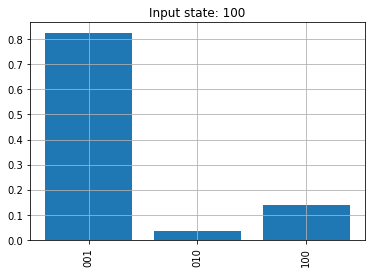

In [23]:
# Probability distribution of sending a photon in the 1st mode through a haar random unitary
probs_bs1 = BosonSampler.get_theo_prob({"100": 1}, generate_haar_unitary(3))
plot_probs(probs_bs1)

### The post-processing

As we already stated above, the output of the entropy source is not expected to be uniform (e.g: the boson sampling experiment). So, we need to carry a post-processing to obtain a uniform and unbiased random output.

#### The Von Neumann post-processing steps:

Given two samples $s_1$ and $s_2$. We would build our uniform bitstring by:
1. Appending $0$ to our bitstring whenever the i-th element of the sample $s_1$ is greater or equal $1$ and the i-th element of the sample $s_2$ is equal to $0$.
2. Appending $1$ to our bitstring whenever the i-th element of the sample $s_1$ is equal to $1$ and the i-th element of the sample $s_2$ is greater or equal $1$.

#### The theory behind the Von Neumann post-processing: independent elements

Let's assume that we have sample $S$  from an arbitrary (discrete) distribution. The probability that an element of $S$ is equal to 0 is noted $p$. The probability that an element of $S$ is not equal to $0$ is then $1 - p$. Every element from the sample is independent from the others.


We can split that sample $S$ into two samples $V$ and $W$. We know that the samples $V$ and $W$ **should follow the same distribution** as the sample $S$.

##### The probability of appending 0 to the bitstring:

To append $0$ to the bitstring, we should have $V_i \geq 1$ and $W_i = 0$ where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i \geq 1) = 1 - p \quad P(W_i = 0) = p$$


Thus, the probability to append $0$ is:

$$ P(V_i \geq 1 \text{ and } W_i = 0) = (1 - p) \; p$$

##### The probability of appending 1 to the bitstring:

To append $1$ to the bitstring, we should have $V_i = 0$ and $W_i \geq 1$ where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i  = 0) = p \quad P(W_i \geq 0) = 1 - p$$


Thus, the probability to append $1$ is:

$$ P(V_i  = 0 \text{ and } W_i \geq 0) = (1 - p) \; p$$


We can see that the probability that we append $0$ is equal to the probability to append $1$ and thus despite starting with a distribution far from being uniform. We can reach a uniform one.

$$ P(\text{ append } 0) =  P(\text{ append } 1) = (1 - p) \; p$$

##### The probability of discarding the i-th element:
We are also interested in knowing the probability of discarding the $i$-th element as this would impact the rate and cost of our random number generator.

$$ P(\text{ discarding the i-th element }) =  1 - P(\text{ appending } 0) - P(\text{ appending } 1) = 1 - 2p + 2p^2$$

To minimize this probability, We need: $p = 0.5$. As can be checked by looking at the following plot:

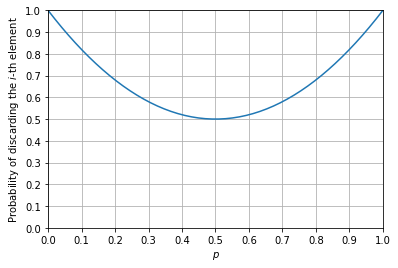

In [24]:
p = np.linspace(0, 1)
plt.plot(p, 1 - 2 * p + 2 * p**2)
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r"$p$")
plt.ylabel(r"Probability of discarding the $i$-th element")
plt.show()

Knowing this, we can for example try to maximize the efficienty of our random number generator by configuring it (as long as it is possible) to have $p = 0.5$.

For the Qubit-based system, this can be done by applying the hadamard gate on our initial $\ket{0}$ qubit. We would obtain:

$$p = P(0) = P(1) = 0.5$$

And we would be able to harness half of our generated sample to get a random bitstring.

If we apply an $R_y$ gate, for example, with angle $\pi / 5$, we would have:

In [25]:
p = np.cos(np.pi / 10)**2

$$p = P(0) = \cos\left(\frac{\pi / 5}{2}\right)^2 \approx 0.90 $$

In [26]:
1 - 2 * p + 2 * p**2

0.8272542485937366

And we would loose 82.7% of our sample, which is a considerable lost.

#### the Von Neumann Post-processing: dependent elements

Let's now assume that the element of our sample $S$ are not independent from one another, in this case the theory becomes more complicated. So, in the interest of time and clarity, let's proceed through examples and observations.

##### Example 01:

Let's assume that we are carrying a boson sampling experiment by sending 2 photons through a 2-mode interferometer.

The possible output that can be detected are: $[1, 1], [2, 0], [0, 2]$ where the first number in the list indicates the number of photons detected in the first detector and the second number indicates the number of photons detected in the second detector.

Let's also assume that the probability to obtain $[1, 1]$ is noted $p_1$, the probability to obtain $[2, 0]$ is $p_2$ and the probability to obtain $[0, 2]$ is $p_3$.

Let's assume that we carried a series of this experiement and obtain a sample of results $S$ and we are interested in the probability to append $0$ and $1$ if we follow the post-processing discussed above.

| $V_i$    | $W_i$    | Probability | Post-processed bitstring |
|----------|----------|-------------|--------------------------|
| $[1, 1]$ | $[1, 1]$ | $p_1^2$     | $[]$                     |
| $[1, 1]$ | $[2, 0]$ | $p_1 p_2$   | $[0]$                    |
| $[1, 1]$ | $[0, 2]$ | $p_1 p_3$   | $[0]$                    |
| $[2, 0]$ | $[1, 1]$ | $p_2 p_1$   | $[1]$                    |
| $[2, 0]$ | $[2, 0]$ | $p_2^2$     | $[]$                     |
| $[2, 0]$ | $[0, 2]$ | $p_2 p_3$   | $[0, 1]$                 |
| $[0, 2]$ | $[1, 1]$ | $p_3 p_1$   | $[1]$                    |
| $[0, 2]$ | $[2, 0]$ | $p_3 p_2$   | $[1, 0]$                 |
| $[0, 2]$ | $[0, 2]$ | $p_3^2$     | $[]$                     |

As we can see, we can append $0$ and $1$ to our bitstring, but we can also append the "words" $01$ or $10$. 

Now, for the bitstring to be truly unbiased the probability of having $0$ or $1$ should be equal BUT ALSO the probability to have $00$, $01$, $10$, $11$ should be equal (and the same applies for longer combinations of 0,1).  An illustration of a bitstring where the $P(0) = P(1)$ but the bitstring is not random is this $01010101$. We can see that $P(0) = P(1)$ but given that we know that the $i$-th is $0$ we are guaranteed that the $i+1$-th bit is 1 and vice versa. A bias might be more suble where given that we know that the $i$-th is a certain value there is unequal probabilities for $i+1$-th bit to be $0$ or $1$.

**Is $P(00) = P(01)$ for the sampling experiment above?**

$$P(0) = p_1 p_2 + p_1 p_3  \qquad P(1) = p_2 p_1 + p_3 p_1$$

So, $$P(0) = P(1)$$. Let's check $P(00)$ and $P(01)$:
$$P(00) = P(0) \; P(0) \qquad P(01) = P(0) \; P(1) + p_2 p_3$$

In [27]:
def ex1_p_0(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1 * p2 + p2 * p3

In [28]:
def ex1_p_1(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1 * p2 + p2 * p3

In [29]:
def ex1_p_00(p1, p2):
    return ex1_p_0(p1, p2)**2

In [30]:
def ex1_p_01(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return ex1_p_0(p1, p2) * ex1_p_1(p1, p2) + p2 * p3

In [31]:
def ex1_diff_p00_p01(p1, p2):
    return  ex1_p_00(p1, p2) - ex1_p_01(p1, p2)

In [32]:
p1 = np.linspace(0, 1)
p2 = np.linspace(0, 1)
mp1, mp2 = np.meshgrid(p1, p2)

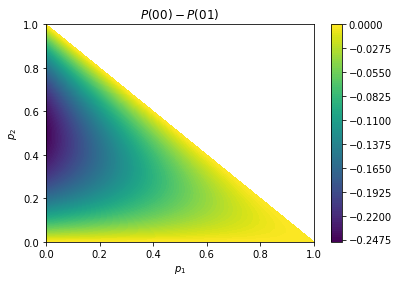

In [33]:
plt.contourf(mp1, mp2, ex1_diff_p00_p01(mp1, mp2), levels=100)
plt.colorbar()
plt.xlabel("$p_1$")
plt.ylabel("$p_2$")
plt.title("$P(00) - P(01)$")
plt.show()

As we can see unless the $p_i$ are fine-tuned, the probabilities of having $00$, $01$ in this example (and in general) are unequal, which would introduce some bias. 

Let's now see what is the probability of not appending anything to our bitstring. 

$$P(\text{not appending}) = p_1^2 + p_2^2 + p_3^2$$

In [34]:
def ex1_p_not_appending(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1**2 + p2**2 + p3**2

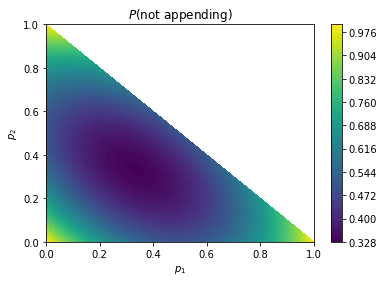

In [35]:
plt.contourf(mp1, mp2, ex1_p_not_appending(mp1, mp2), levels=100)
plt.colorbar()
plt.xlabel("$p_1$")
plt.ylabel("$p_2$")
plt.title("$P($not appending$)$")
plt.show()

We can see that the advantage of having dependent elements in our sample is that we can reach smaller probabilities of not appending anything to our bitstring, which means that we would have less waste and longer bitstrings.

##### Example 02:

Let's try to go a level harder and try to carry a boson sampling experiment like the one describe in section (3.2) of [Shi et al.](#References).

In this experiment, we are sending two photons into a 5-mode interferometer and collecting the results. We implemented a boson sampling simulator which we can use to to carry this experiment and study the output.

In [36]:
probs_ex2 = BosonSampler.get_theo_prob(shi_input_dict, shi_unitary5)

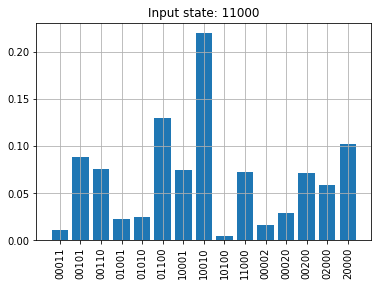

In [37]:
plot_probs(probs_ex2)

As you can see, we retrieve the same probability distribution as in figure 4. (a). Now, let's see what we would obtain we we draw random samples from this distribution and postprocess them:

In [38]:
study_boson_sampler(probs_ex2)

{'': 0.44304139369062234,
 '01': 0.6249299343169981,
 '0011': 0.05689875094630071,
 '1': 0.345105289406096,
 '011': 0.18773149775052814,
 '10': 0.6249299343169981,
 '0101': 0.10730937865653906,
 '101': 0.1890817329403677,
 '0110': 0.1898526313346462,
 '110': 0.07755980340426805,
 '1001': 0.1898526313346462,
 '1010': 0.10730937865653906,
 '1100': 0.05689875094630071,
 '0': 0.3451052894060961,
 '001': 0.07755980340426803,
 '010': 0.1890817329403677,
 '100': 0.18773149775052814}

The function `study_boson_sampler` takes the output of `BosonSampler.get_theo_prob` and output a dictionnary whose keys are "words" and the values are the probabilities that these "words" gets appended to our final bitstring. 

As we can see the probability that nothing gets appended to the bitstring is very low 11% compared the minimal 50% for independent elements case. 

But, as we saw in the previous example, this comes at price which is that in the general case unless we choose our unitary very carefully there would be a small bias in our final bitstring as the probability of to have certain blocks in our bitstring is higher to the probability of having other blocks.

##### Example 03:

Let's look at another example in which the bias is more clear. Let's pick a 10-mode interferometer and send either two-photons in the 5th and 6th mode or in the 4th and 7th mode with probability 50% for each (look at the `ex3_input` below).

In [50]:
from scipy.linalg import block_diag
ex3_input = {"0000110000": 0.5, "0001001000": 0.5}
ex3_unitary = block_diag(generate_haar_unitary(5), shi_unitary5)

In [51]:
probs_ex3 = BosonSampler.get_theo_prob(ex3_input, ex3_unitary)

In [52]:
study_boson_sampler(probs_ex3)

{'': 0.08596071717769593,
 '01': 0.21281077157568346,
 '0101': 0.12210539221865062,
 '10': 0.21281077157568348,
 '0110': 0.1221053922186506,
 '1001': 0.12210539221865065,
 '1010': 0.12210539221865067}

As you can see here, the bias in the bitstring would be more obvious in this case. Given a bitstring generated with such an input and unitary. If we have $00$, we are certain that the next bit would be a $1$ and vice versa (if you are unsure why this is the case, try to pick any random two "words" from the results above and try to construct a bitstring with 3 consecutive $0$ or $1$, this is impossible.)

#### Post-processing: dependent elements, the unbiased way

As we just saw, if we have a sample whose elements are dependent, we can generate bitstrings with less losses but at the cost of introducing suble (or less suble) biases. 

In what follows, we propose a post-processing schema to generate an unbiased bitstring from a sample with dependent elements.

First lets. observe that in the example 2 and example 3, the probabilities to append a word which starts with a $0$ is similar to the probability of appending a word which starts with a $0$. (for example (2): the probabilities are ~ 44.46% and for example (3): the probabilities are 47%)


1. We pass the sample through the Von Neumann post-processing.
2. Instead of appending the words produced in the previous step to the bitstring, we append a $0$ to the bitstring if the word starts with $0$ and $1$ if the word starts with a $1$. 

## Testing the randomness

<img src="https://i.imgur.com/dmhKrL3.jpg" style="height: 200px" />

Now, that we have methods to generate random numbers. We need a test to measure how random they are. As we saw in the previous section, looking for the frequencies of $0$s and $1$s is not enough. We should also look for repeating words, patterns, and etc. In what follows, we will assess the randomness of our bitstring by the using the [nistrng package](https://pypi.org/project/nistrng/), which is a python package implementing the 15 tests of the [NIST SP 800-22](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf) test-suite. A pedagogical review of some the tests can be found [here](https://medium.com/unitychain/provable-randomness-how-to-test-rngs-55ac6726c5a3). 

Beside that, we will also plot the distribution of the different BITs, BYTEs (8-bits), WORDs (16-bits), and DWORDs (32-bits) so that reader can have an simple visual representation of how unbiased (or biased) the outputs are. 

## The CQT RNG package

<img src="CQT_RNG.jpeg" />

We gathered all the necessary code to generate a random bitstring and developped a package that was designed to be simple and extendable. The core of the package are three classes. The `RNG`, `EntropySource`, and `PostProcessor` classes. 

The `RNG` classes takes an entropy source and a postprocessor. The entropy source should be a subclass of the `EntropySource` abstract class and the postprocessor should be a subclass of the `PostProcessor` abstract class. 

This leaves plenty of room for the end-user to add his own entropy sources and post processors.

We also provide some entropy sources:
* `UniversalQCSampler`: Based on the [Qubit approach](#Quantum-RNG:-Qubits), simulated on qiskit's [aer_simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.AerSimulator.html).
* `ShiSFSampler`: Based on the approach described in [Shi et al.](https://arxiv.org/pdf/2206.02292.pdf), simulated on Strawberry Fields' [fock backend](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.FockBackend.html).
* `BosonSampler`: Simulates a boson sampling experiment. Default arguments simulate the Shi et al. circuit. Faster than the Strawberry fields simulator.
* `IBMQSampler`: Based on the [Qubit approach](#Quantum-RNG:-Qubits), experiment carried on [IBMQ hardware](https://www.ibm.com/quantum).
* `BorealisSampler`: Based on Gaussian Boson Sampling, experiments carried on [Xanadu hardware](https://cloud.xanadu.ai/).
* `Loader`: An entropy source which delivers samples from data inputted as `np.array` or load it from a `.npy` file.

We also provide two postprocessors:
* `VonNeumannPP`: Based on the [Von Neumann postprocessing](#The-Von-Neumann-post-processing-steps:)
* `CQTPP`: Based on the approach described [here](#Post-processing:-dependent-elements,-the-unbiased-way)

### Qubits-based Simulator

To generate a bitstring of length 100 using the [Qubit-based approach](#Quantum-RNG:-Qubits) as an entropy source and the [Von Neumann postprocessor](#The-Von-Neumann-post-processing-steps:):

In [43]:
from cqt_rng import RNG
from cqt_rng.entropy_sources import UniversalQCSampler
from cqt_rng.post_processors import VonNeumannPP


es1 = UniversalQCSampler(nb_qubits = 5)
pp1 = VonNeumannPP()
rng1 = RNG(entropy_source=es1, postprocessor=pp1)

In [46]:
rng1.generate(100)

102it [00:00, 505.69it/s]                                                                                                                                                 


array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int8)

### Shi et al. Simulator(s)

### Real Devices: IBMQ

### Real Devices: Borealis

## Conclusions

In [10]:
from package.cqt_rng.base.rng import RNG

In [11]:
from package.cqt_rng.simulators.qubits_sampler import QubitsSampler

In [12]:
from package.cqt_rng.simulators.shi_sampler import ShiSampler

In [13]:
from scipy.linalg import block_diag

In [14]:
rng1 = RNG(entropy_source=QubitsSampler())

In [15]:
rng1.generate(24)

27it [00:00, 192.62it/s]                                                        


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0])

In [16]:
unitary5 = ShiSampler.generate_haar_unitary(5)
unitary10 = block_diag(unitary5, unitary5.T)

In [17]:
# rng2 = RNG(entropy_source=ShiSampler(unitary = unitary10))

In [18]:
# rng2.generate(10)

In [19]:
unitary3 = ShiSampler.generate_haar_unitary(3)

In [20]:
rng3 = RNG(entropy_source=ShiSampler(with_sf = True, unitary = unitary3))

In [21]:
# rng3.generate(20)

In [37]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.tools.monitor import job_monitor

In [38]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 1 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-08-17 22:08:17,913: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila


In [39]:
nb_qubits = backend.configuration().n_qubits

print(f"Running the job on {backend} with {nb_qubits} qubits!")

qc = QuantumCircuit(nb_qubits)

for i in range(nb_qubits):
    qc.h(i)
    
qc.measure_all()

Running the job on ibmq_manila with 5 qubits!


In [45]:
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, memory=True)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [46]:
results = job.result()

In [47]:
results.get_memory()

['10100',
 '00101',
 '01000',
 '00100',
 '10110',
 '10100',
 '01100',
 '10010',
 '10010',
 '11001',
 '11010',
 '10000',
 '00100',
 '10110',
 '10110',
 '01010',
 '11010',
 '10100',
 '00001',
 '01010',
 '11010',
 '11100',
 '10110',
 '01111',
 '01001',
 '00111',
 '11111',
 '10010',
 '11000',
 '01000',
 '00001',
 '00011',
 '10011',
 '11111',
 '01011',
 '11110',
 '11101',
 '11011',
 '11000',
 '01000',
 '01100',
 '00111',
 '11001',
 '01001',
 '10001',
 '11011',
 '00000',
 '11001',
 '01000',
 '00011',
 '00011',
 '10101',
 '10100',
 '10111',
 '11100',
 '00100',
 '10001',
 '10010',
 '01001',
 '11100',
 '00000',
 '10010',
 '01111',
 '01000',
 '10110',
 '10101',
 '11100',
 '00000',
 '00001',
 '00101',
 '10110',
 '01010',
 '10011',
 '00111',
 '11101',
 '00100',
 '00110',
 '11010',
 '10100',
 '00101',
 '00110',
 '11111',
 '00011',
 '10001',
 '11010',
 '00101',
 '11001',
 '01111',
 '11100',
 '00101',
 '10011',
 '10010',
 '11011',
 '00101',
 '00000',
 '00100',
 '00000',
 '00001',
 '00101',
 '01011',


In [54]:
bitstring_str = "".join(results.get_memory())

In [56]:
data_arr = np.array(list(bitstring_str)).astype(int)

In [58]:
s1 = data_arr[:10000]

In [59]:
s2 = data_arr[10000:]

In [61]:
np.size(s2)

10000

In [64]:
def postprocess(sample_1, sample_2):
    """
        TODO: Von-Neumann post-processing
    """
    bitstring = []
    for bit_1, bit_2 in zip(sample_1, sample_2):
        if bit_1 == 0 and bit_2 != 0:
            bitstring.append(1)
        elif  bit_1 != 0 and bit_2 == 0:
            bitstring.append(0)

    return bitstring

In [65]:
rng = postprocess(s1, s2)

In [67]:
np.size(rng)

5016

In [68]:
def bitstring_to_8b_nbs(bitstring):
    """
    Transform the 01 bitstring into char numbers (8bits)
    """
    bs = np.copy(bitstring)
    diff = 8 - (np.size(bs) % 8)
    bs = np.pad(bs, (0, diff), 'constant', constant_values=2)
    r = np.size(bs) // 8
    cropped_bs = np.resize(bs, (r, 8))[:-1, :]
    useful_r = r - 1 if diff else r 
    res = []
    for i in range(useful_r):
        d = int("".join(cropped_bs[i, :].astype(str)), 2)    
        res.append(d)
    return np.array(res)

In [69]:
rng_8b = bitstring_to_8b_nbs(rng)

In [73]:
import nistrng

def nist_tests(bitstring):
    # Check the eligibility of the test and generate an eligible battery from the default NIST-sp800-22r1a battery
    eligible_battery: dict = nistrng.check_eligibility_all_battery(bitstring, nistrng.SP800_22R1A_BATTERY)
    # Print the eligible tests
    print("Eligible test from NIST-SP800-22r1a:")
    for name in eligible_battery.keys():
        print("-" + name)
    # Test the result on the eligible tests
    results = nistrng.run_all_battery(bitstring, eligible_battery, False)
    # Print results one by one
    print("Test results:")
    failed = 0
    for result, elapsed_time in results:
        if result.passed:
            print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
        else:
            failed += 1
            print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    print(f"Total failed tests: {failed}/{len(eligible_battery.keys())}")

In [72]:
print(f"The percentage of 1 bits: {np.sum(rng) * 100 / 5016}%")

The percentage of 1 bits: 49.04306220095694%


In [75]:
nist_tests(np.array(rng))

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-dft
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
-random_excursion
-random_excursion_variant
Test results:
- PASSED - score: 0.175 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.144 - Frequency Within Block - elapsed time: 2 ms
- PASSED - score: 0.629 - Runs - elapsed time: 6 ms
- PASSED - score: 0.368 - Longest Run Ones In A Block - elapsed time: 0 ms
- PASSED - score: 0.14 - Discrete Fourier Transform - elapsed time: 5 ms
- PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 22 ms
- PASSED - score: 0.422 - Serial - elapsed time: 148 ms
- PASSED - score: 0.181 - Approximate Entropy - elapsed time: 116 ms
- PASSED - score: 0.198 - Cumulative Sums - elapsed time: 5 ms
- FAILED - score: 0.079 - Random Excursion - elapsed time: 23 ms
- PASSED - score: 0.562 - Random Excursion Variant - elapsed time: 2 ms
Total failed tests: 1

## References

1. [An Unbiased Quantum Random Number Generator Based
on Boson Sampling](https://arxiv.org/pdf/2206.02292.pdf)
1. [NIST SP 800-22](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf)
1. [Provable Randomness: How to Test RNGs](https://medium.com/unitychain/provable-randomness-how-to-test-rngs-55ac6726c5a3)
1. [On the interpretation of results from the NIST statistical test suite](https://www.researchgate.net/publication/287224641_On_the_interpretation_of_results_from_the_NIST_statistical_test_suite)
1. [Quantum computational advantage with a programmable photonic processor](https://www.nature.com/articles/s41586-022-04725-x)